In [1]:
import os, sys, time, resource, re, gc, shutil
import operator
from multiprocess import Pool
from functools import partial
from urllib.parse import urlparse, parse_qsl
from django.db.models import Count
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from adjustText import adjust_text

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Sum, Count
from matplotlib import gridspec

from utils.utils import *


import statsmodels.formula.api as sm, statsmodels.stats.api as sms

from run_id import run_id

run_id = 662

runstat = RunStats.objects.get(pk=run_id)
topics = DynamicTopic.objects.filter(run_id=run_id)

docs = Doc.objects.filter(
    query=runstat.query,
    content__iregex="\w"
)



/usr/lib/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


In [2]:
years = list(range(1990,2015))
years

s_solutions = []
ip_solutions = []

r = "solution|political action|policy"

for y in years:
    ydocs = docs.filter(PY=y)
    sdocs = ydocs.filter(content__iregex=r)
    s_count = sdocs.count()
    s_solutions.append(s_count/ydocs.count())
    ip_docs = ydocs.filter(ipccref__isnull=False)
    ip_solution_docs = ip_docs.filter(content__iregex=r)
    try:
        ip_solutions.append(ip_solution_docs.count()/ip_docs.count())
    except:
        ip_solutions.append(0)
    #ipdocs = ydocs.filter()
    

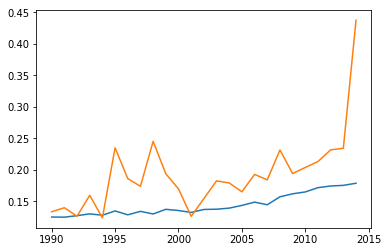

In [3]:
plt.plot(years,s_solutions)
plt.plot(years, ip_solutions)
plt.show()

In [7]:
dts = DocTopic.objects.filter(
    run_id=run_id,
    doc__PY__lt=2014,
    score__gt=runstat.dthreshold,
    topic__topicdtopic__dynamictopic__run_id=run_id,
    topic__topicdtopic__score__gt=runstat.dthreshold
).values('topic__topicdtopic__dynamictopic__id')

dts = dts.annotate(
    solution = models.Sum(
        models.Case(
            models.When(
                doc__content__iregex=r,
                then=F('score')*F('topic__topicdtopic__score')
            ),
            default=0,
            output_field=models.FloatField()
        )
    )
)


In [8]:
df = pd.DataFrame.from_dict(list(dts.values(
    'topic__topicdtopic__dynamictopic__title',
    'solution',
    'topic__topicdtopic__dynamictopic__score'
)))

In [6]:
df.head()

,no_ipcc,solution,topic__topicdtopic__dynamictopic__id
0,35.368370,35.368370,10738
1,33.298057,33.298057,10780
2,108.833456,108.833456,10792
3,61.540923,61.540923,10761
4,68.358017,68.358017,10766
